# Análisis exploratorio

A continuación vamos a analizar los features y su estructura, para ver si, de este modo, podemos tener una idea más clara de qué features pueden ser más útiles a la hora de realizar nuestro análisis predictivo.

In [2]:
import pandas as pd

In [17]:
from sklearn.feature_selection import f_classif

In [3]:
import numpy as np

In [4]:
data = pd.read_csv('meg_mci.csv')

In [5]:
data.head(5)

,id,class,sync_1_2.mean,sync_1_3.mean,sync_1_4.mean,sync_1_5.mean,sync_1_6.mean,sync_1_7.mean,sync_1_8.mean,sync_1_9.mean,...,sync_98_102.cov,sync_99_100.cov,sync_99_101.cov,sync_99_102.cov,sync_100_101.cov,sync_100_102.cov,sync_101_102.cov,errank cov,errank mean,errank std
0,10,2,0.16524,0.14092,0.28587,0.30593,0.099007,0.11985,0.081729,0.19688,...,0.16895,0.112930,0.14741,0.17948,0.103410,0.133580,0.134290,26.845063,53.292877,47.433753
1,101,1,0.24350,0.21801,0.33973,0.37038,0.152750,0.19048,0.107900,0.21108,...,0.14521,0.083891,0.11734,0.16435,0.105470,0.122850,0.107800,33.915705,55.198650,52.141520
2,102,1,0.22693,0.23916,0.34658,0.48029,0.156820,0.21248,0.108420,0.21803,...,0.16983,0.109880,0.12806,0.15621,0.121340,0.113170,0.106190,30.763512,53.891165,51.685973
3,103,2,0.20167,0.21468,0.31721,0.36042,0.139720,0.17884,0.107090,0.22455,...,0.13883,0.084963,0.15452,0.16742,0.132600,0.144990,0.125710,26.131415,52.407543,49.487205
4,104,1,0.17611,0.16305,0.28046,0.31670,0.091437,0.11205,0.077060,0.14538,...,0.14472,0.078506,0.13249,0.18052,0.078152,0.086651,0.095044,35.038180,57.143868,53.377415


In [6]:
target = data['class']
data = data.iloc[:, 2:]

In [9]:
%matplotlib inline

## Redundancia entre mediciones.

Los features son estadísticos tomados sobre la sincronización de pares de sensores MEG.
Algunos de estos estadísticos son muy similares funcionalmente así que es probable que haya mucha redundancia.

En concreto, la media (mean) va a ser muy similar a la mediana (med) y la desviación estándar (std) va a ser muy similar a la diferencia absoluta media.

Para comprobar si esto es cierto, se va a medir, dentro de cada observación, las correlaciones entre los tipos de features.


In [10]:
stats = ['mean', 'cov', 'mad', 'std', 'med']
groups = []
for stat in stats:
    groups.append([c for c in data if stat in c])

In [11]:
names = [ s+'_'+j for i, s in enumerate(stats) for j in stats[i+1:]]

In [12]:
corrs = pd.DataFrame(columns=names)
for i in data.index:
    d = []
    for g in groups:
        d.append(data.loc[i, g].values.reshape(-1, 1))
    d = np.concatenate(d, axis=1)
    corrs.loc[i] = np.corrcoef(d.T)[np.triu_indices(5, k=1)]

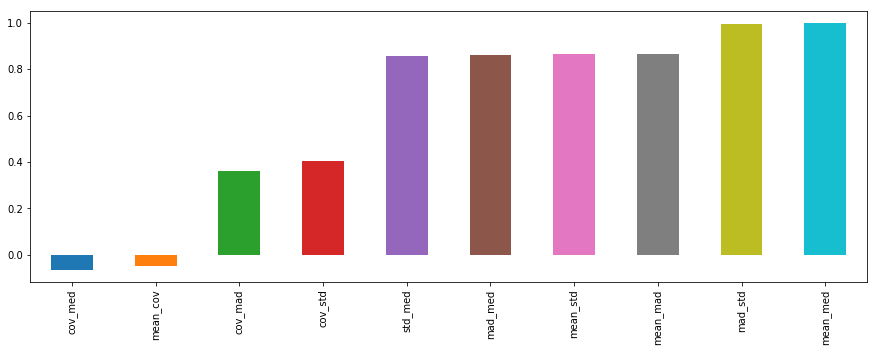

In [13]:
corrs.median().sort_values().plot.bar(figsize=(15, 5))

Básicamente, esto quiere decir que la deviación estándar y la MAD son totalmente equivalentes, al igual que la media y la mediana.
Nos quedamos únicamente con la media y con la desviación estándar.
Además sabemos que:
1. La covarianza y la media prácticamete no se parecen.
2. La covarianza y la desviación estándar tampoco tienen correlación demasiado alta.
3. La desviación estándar y la media sí tienen una correlación bastante significativa.
Nos quedamos solo con:
Covarianza, desviación estándar y media.

In [14]:
data = data[[c for c in data if ('mean' in c)| ('std' in c)| ('cov' in c)]]

## Análisis de importancia de los features

### Análisis ingenuo de features

Primeramente, se va a llevar a cabo un análisis totalmente naive de la capacidad predictiva de los features.
Se van a hacer un f-test de diferencia de medias masivo (sin ajuste por multiple comparación de hipótesis).
El objetivo no es hacer hallar significatividad estadística sino únicamente ordenar los features por importancia.
Se van a muestrear aleatoriamente las observaciones para tener resultados algo más fiables.

Antes de continuar, se van a dejar 32 observaciones sin incluir para validar las conclusiones este análisis.

In [15]:
holdout = data.iloc[-32:]
data = data.iloc[:-32]

In [484]:
def rank(X):
    fimp = pd.DataFrame(index=X.columns)
    for i in range(50):
        samp = X.sample(frac=0.5)
        fimp[i] = f_classif(samp, target.loc[samp.index])[1]
    return fimp

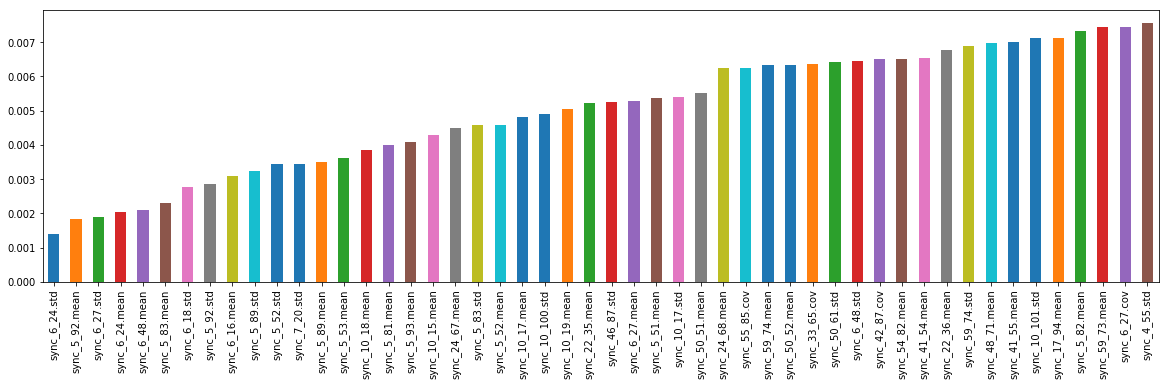

In [492]:
fimp = rank(data)
fimp.median(axis=1).sort_values().iloc[:50].plot.bar(figsize=(20, 5))

A primera vista, parece que hay algunos nodos especialmente importantes, como el 5 y el 6 por ejemplo.
Para evaluar mejor estos resultados, merece la pena sacar estadísticas de la importance de los features, teniendo en cuenta los nodos implicados.

In [493]:
nodos = [[i, j] for i in range(1, 103) for j in range(i+1, 103)]
fquant = fimp.quantile(np.arange(0, 1.1, 0.1), axis=1)
fimp = fimp.median(axis=1).to_frame()
fimp['node 1'] = np.array(nodos*3)[:, 0]
fimp['node 2'] = np.array(nodos*3)[:, 1]
fimp = fimp.rename(columns={0:'pval'})

In [494]:
node_stats = pd.DataFrame()
for i in range(1, 103):
    node_stats.loc[i, 'Avg pval'] = fimp.loc[(fimp['node 1']==i)|(fimp['node 2']==i), 'pval'].median()

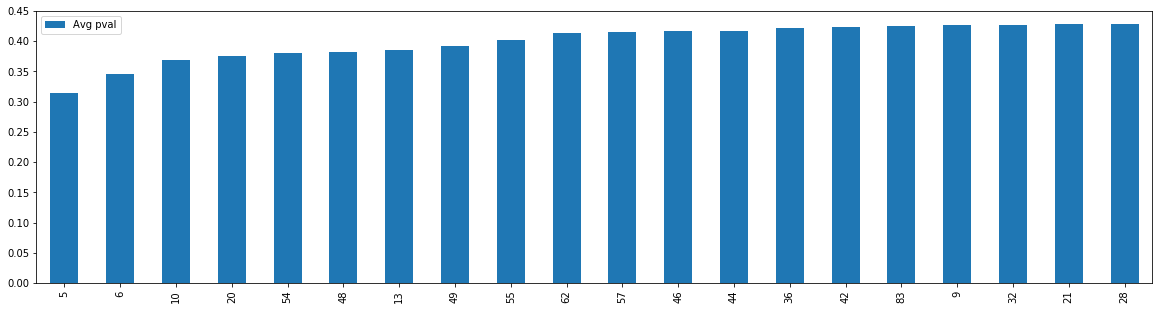

In [495]:
node_stats.sort_values('Avg pval').iloc[:20].iloc[:20].plot.bar(figsize=(20, 5))

Como se puede observar, los nodos más importantes son 5 6 10 54 48 62 etc
Cabe destacar que hay bastantes sensores intermedios entre los más importantes (20-60), mientras que por encima de 60 proximadamente parecen tener menos importancia.
Se aprecia también, que la clave de la informatividad está en la pareja y no en que haya un nodo individual, dado que en estas medias no es tan importante la diferencia.

También es muy directo medir el impacto de cuál es el estadístico más informativo

In [496]:
fimp['stat'] = ['mean']*5151 + ['std']*5151 + ['cov']*5151

(0.4, 0.42)

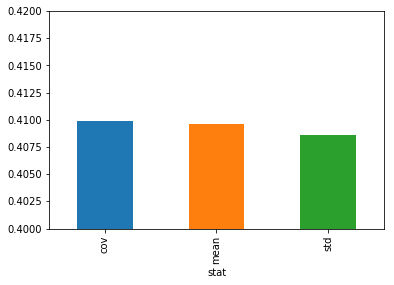

In [497]:
ax = fimp.groupby('stat').mean()['pval'].plot.bar()
ax.set_ylim([0.40, 0.42])

## Regiones de importancia

In [273]:
from scipy.spatial.distance import squareform

In [274]:
imp = {}

In [277]:
for f in ['mean', 'cov', 'std']:    
    clist = []
    for i in tqdm(range(300)):
        cols = [c for c in data if (f in c) & ~('errank' in c)]
        samp = data[cols].sample(frac=0.5, replace=False)
        sy = target.loc[samp.index]
        rnk = pd.Series(f_classif(samp, sy)[1], samp.columns)
        cc = squareform(rnk)
        clist.append(cc.reshape(cc.shape[0], -1, 1))
    ctens = np.concatenate(clist, axis=2)
    del clist
    imp[f] = np.mean(ctens, axis=2)
    del ctens

100%|████████████████████████████████████████| 300/300 [00:08<00:00, 33.90it/s]


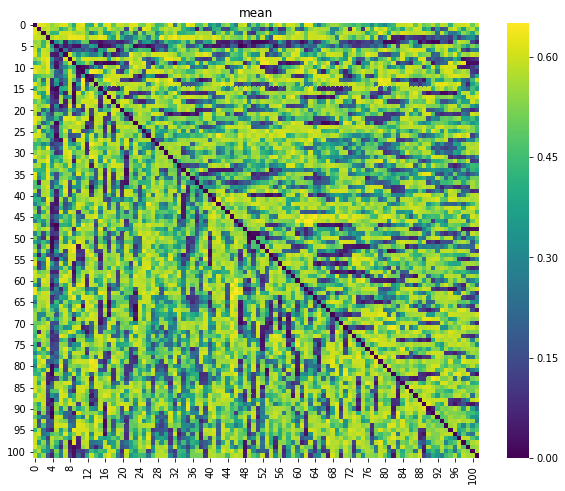

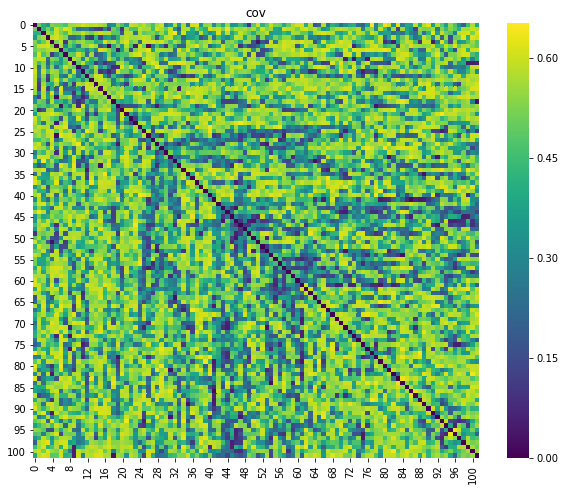

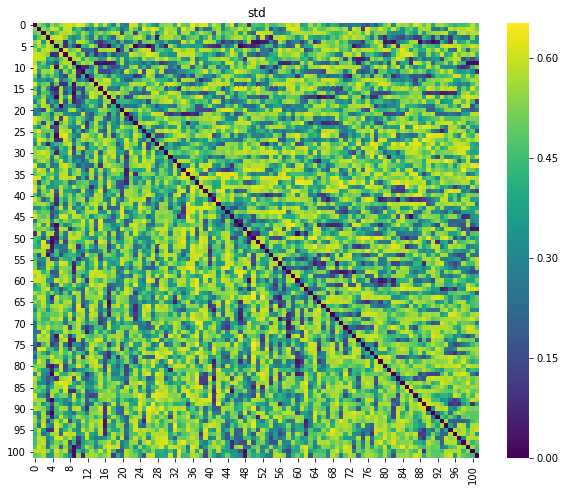

In [278]:
for f in ['mean', 'cov', 'std']:  
    fig = plt.figure()
    sns.heatmap(imp[f], cmap='viridis')
    fig.set_size_inches(10, 8)
    ax = plt.gca()
    ax.set_title(f)

In [279]:
from scipy.ndimage.filters import convolve

In [423]:
kimp = {}
for f in imp:
    kernel =  np.ones((3, 3))/9
    imp[f][imp[f]==0] = np.mean(np.mean(imp[f]))
    kimp[f] = convolve(imp[f], kernel)

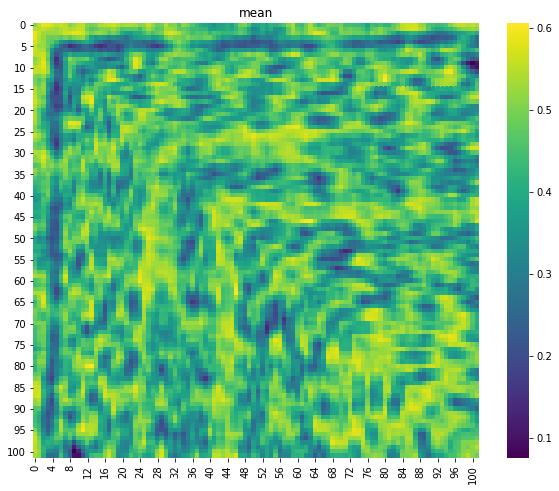

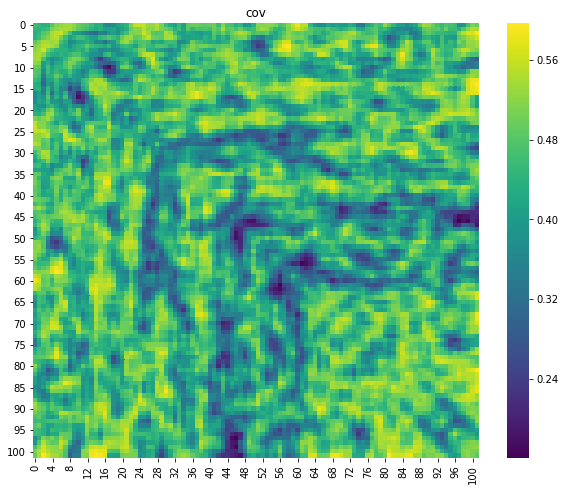

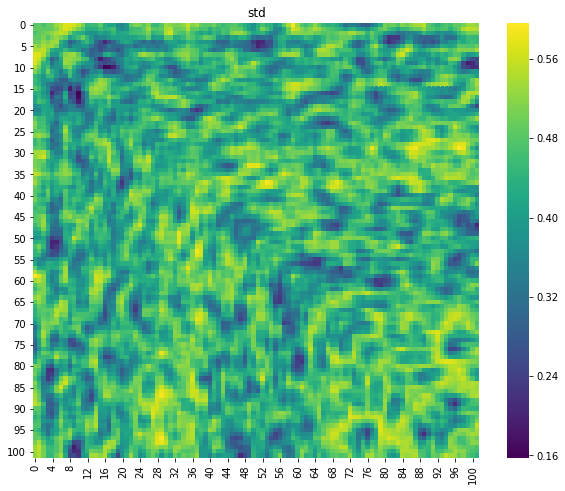

In [479]:
for f in ['mean', 'cov', 'std']:  
    fig = plt.figure()
    kimp[f] = pd.DataFrame(kimp[f])
    sns.heatmap(kimp[f], cmap='viridis')
    fig.set_size_inches(10, 8)
    ax = plt.gca()
    ax.set_title(f)

In [425]:
ws = {f: 1/(kimp[f]+0.1) for f in kimp}

In [416]:
from scipy.spatial.distance import squareform
from tqdm import tqdm

In [417]:
new_feats = {}
for i in tqdm(data.index):
    new_feats[i] = {}
    for f in ['mean', 'cov', 'std']:
        cov = data.loc[i, [c for c in data if f in c]]
        cc = squareform(cov)
        cc[cc==0] = np.mean(np.mean(cc[cc!=0]))
        new_feats[i][f] = cc*ws[f]

100%|████████████████████████████████████████| 100/100 [00:02<00:00, 46.17it/s]


In [418]:
target.head(10)

0    2
1    1
2    1
3    2
4    1
5    1
6    2
7    2
8    1
9    2
Name: class, dtype: int64

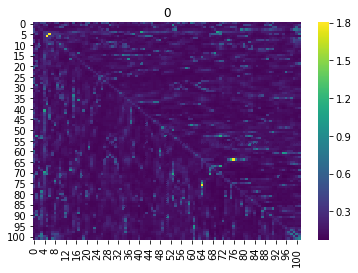

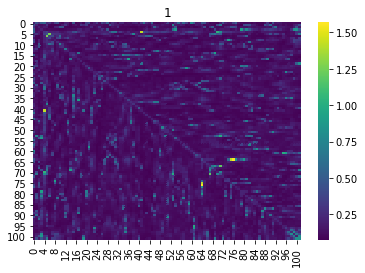

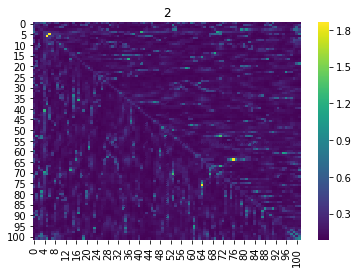

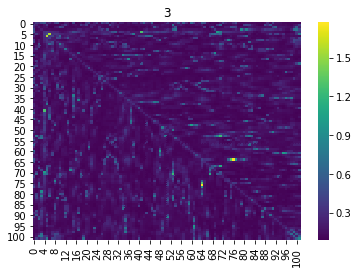

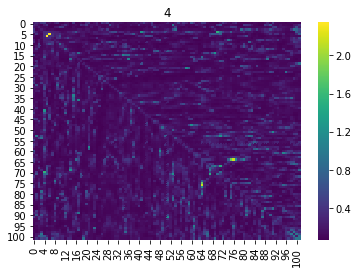

In [480]:
for i in range(5):
    plt.figure()
    sns.heatmap(new_feats[i]['mean'], cmap='viridis')
    fig.set_size_inches(10, 8)
    ax = plt.gca()
    ax.set_title(i)

In [211]:
train_set = {}
for i in tqdm(data.index):
    image = []
    for f in ['mean', 'cov', 'std']:
        cov = data.loc[i, [c for c in data if f in c]]
        cc = squareform(cov)
        cc[cc==0] = np.mean(np.mean(cc[cc!=0]))
        image.append(cc.reshape(cc.shape[0], -1, 1))
    image = np.concatenate(image, axis=2).reshape(cc.shape[0], -1, 3, 1)
    train_set.append(image)
train_set = np.concatenate(train_set, axis=3)
train_set = np.transpose(train_set, axes=[3, 0, 1, 2])

100%|████████████████████████████████████████| 100/100 [00:02<00:00, 47.21it/s]


In [216]:
import seaborn as sns

In [221]:
target.head()

0    2
1    1
2    1
3    2
4    1
Name: class, dtype: int64

In [460]:
target.head()

0    2
1    1
2    1
3    2
4    1
Name: class, dtype: int64

Text(0.5,1,'0')

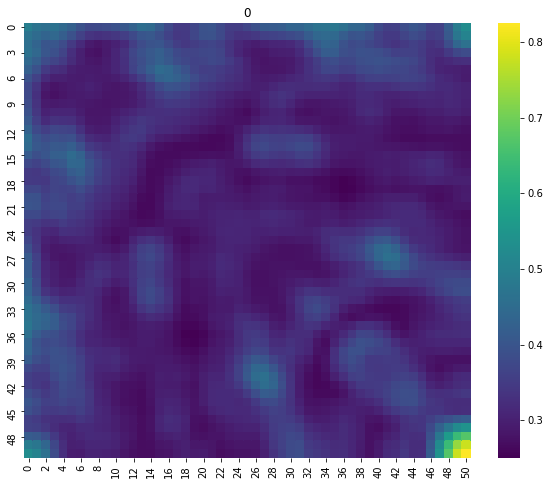

In [464]:
i=0
import skimage.measure
from scipy.ndimage.filters import convolve

cov = data[groups[0]]
cc = squareform(cov.loc[i]) 
cc[cc==0] = np.mean(np.mean(cc[cc!=0]))

kernel = np.ones((4, 4))/16
fig = plt.figure()
conv = convolve(cc, kernel)
kernel = np.ones((4, 4))/16
cc = skimage.measure.block_reduce(conv, (2, 2))
conv = convolve(cc, kernel)
sns.heatmap(conv, cmap='viridis')
fig.set_size_inches(10, 8)
ax = plt.gca()
ax.set_title(i)

In [345]:
eigen = pd.DataFrame()
dens = pd.DataFrame()
errank = pd.Series()
errankmin = pd.Series()
errankmax = pd.Series()
cov = data[groups[0]]
for i in tqdm(cov.index):
    cc = squareform(cov.loc[i]) 
    cc[cc==0] = np.mean(np.mean(cc[cc!=0]))
    eigen[i] = np.linalg.svd(cc)[1]
    dens[i] = eigen[i]/eigen[i].abs().sum()
    errankmin.loc[i] = dens[i].min()
    errankmax.loc[i] = dens[i].max()
    errank.loc[i] = np.exp(-np.sum(dens[i]*np.log(dens[i]) ))

100%|███████████████████████████████████████| 100/100 [00:00<00:00, 117.26it/s]


In [346]:
from sklearn.feature_selection import mutual_info_classif, f_classif

In [347]:
print(mutual_info_classif(errank.values.reshape(-1, 1), target.loc[data.index]))
print(f_classif(errank.values.reshape(-1, 1), target.loc[data.index]))

[0.07724783]
(array([2.75957525]), array([0.09986995]))


Realmeante, la diferencia en cuanto a la potencia de los estadísticos es bastante pequeña.

## Análisis con grafos

Dado que la informatividad está concretamete en las relaciones específicas, un análisis de grafos sería muy interesante.

In [55]:
import networkx as nx

Primero, una lista de grafos con las medias (que son las más informativas)

In [119]:
graphs = [nx.empty_graph() for _ in data.index]
means = data[groups[0]]
for j in range(len(graphs)):
    graphs[j].add_nodes_from(list(range(1, 103))) 
    graphs[j].add_weighted_edges_from([ nodo + [means.iloc[j, i]]  for i, nodo in enumerate(nodos)])

In [173]:
vals = np.percentile(means.values.ravel(), [10, 25, 50, 75, 99.5])

In [ ]:
G=graphs[0]

elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] > vals[-1]]
weight = [d for (u, v, d) in G.edges(data=True) if d['weight'] > vals[-1]]
pos = nx.circular_layout(G)  # positions for all nodes
# nodes
posl1= {e[0]: pos[e[0]] for e in elarge}
posl2 = {e[1]: pos[e[1]] for e in elarge }

nx.draw_networkx_nodes(G, pos, nodelist=list(set([e[0] for e in elarge])), node_size=700)
nx.draw_networkx_nodes(G, pos, nodelist=list(set([e[1] for e in elarge])) , node_size=700)
# edges
nx.draw_networkx_edges(G, pos, edgelist=elarge, edge_cmap=plt.cm.viridis)
# labels
nx.draw_networkx_labels(G, posl1, font_size=20, font_family='sans-serif')
nx.draw_networkx_labels(G, posl2, font_size=20, font_family='sans-serif')
fig = plt.gcf()
fig.set_size_inches(10, 10)